# [Steem Analysis] Whale Tagging: What Are the Whale-est Tags?

Sometimes you just get the inspiration to find something out, and sometimes it's given to you.

Whale chasing is a full-time hobby on Steemit for some; tracking the motion and activity of the elusive high-SP accounts in order to try and court their interest by catering to a very specific crowd. It's not really what I want to do with my time, but there are certain aspects that I find interesting.

In other posts I have worked to determine what the most influential accounts on the site really are, how many of them it takes in one place to outvote everybody else (the answer is roughly 92, in case you were curious), and what the pattern of transfers of funds between them actually looks like.

@kipswolfe set what I originally thought was going to be a trivial challenge: find out what tax the whales on the platform prefer to vote for.

This sounds as if it should be trivial.

It turns out that it's a lot harder than it looks, mainly because of the way that votes record their targets on the blockchain. But we'll get to that.

## Whaling Lists

I wanted to do something a little bit different with this particular instance. In the past, I haven't been taking delegated SP into account when building my lists of important accounts. In a real sense, that doesn't make a big difference, if we're being honest.

Because of the ridiculous orders of magnitude between high-SP accounts at the top end, it really doesn't matter much if one of the big players has delegated a million vests here and there. It's lower than noise in the signal. As a personal challenge, however, I wanted to figure out how to take that into account.

Let's do some basic set up first. It's the usual toolchain.

In [276]:
from steemdata import SteemData
import datetime
from datetime import datetime as dt
import collections

import pandas as pd

Rather than keep isolating these particular settings, I've decided to move them into actual standalone variables. It doesn't matter a lot for this particular problem, but since I tend to go heavy on code reuse, this will come in very handy in a future article.

In [277]:
DAYS, WHALES = 7, 100

There is no easy way to get a list of bots. In fact, creating that list in an automated fashion is probably worth two or three PhD theses for someone else. I'm going to cheat a little bit and manually transcribe a list of bots from https://steembottracker.com/ .

Manually.

This is not my favorite way to do things, and I wish that Steem Bot Tracker had some sort of API in order to query it for its known list of bots, but this will do for now.

I've also added a few apps that I know are pretty aggressive about voting up things and which I would really rather drop off. They don't really add to the answer to the question as posed.

In [278]:
SteemBots = ['booster', 'upme', 'appreciator', 'sneaky-ninja', 'rocky1', 'smartsteem',
             'therising', 'jerrybanfield', 'upmyvote', 'mercurybot', 'promobot', 'postpromoter', 
             'buildawhale', 'boomerang', 'minnowbooster', 'randowhale', 'smartmarket',
             'lays', 'speedvoter', 'upvotewhale', 'bumper', 'ebargains', 'treeplanter', 'tipu', 
             'postdoctor', 'morwhale', 'drotto', 'minnowpond', 'moonbot', 'danzy', 'echowhale',
             'originalworks', 'siditech', 'byresteem', 'withsmn', 'alphaprime', 'steemvote',
             'hugwhale', 'blockgators', 'steemvoter', 'hottopic', 'thundercurator', 
             'earthnation-bot', 'resteemable', 'photocontests', 'friends-bot', 'frontrunner',
             'resteembot', 'astrobot', 'steemlike', 'earnmoresteem', 'followforupvotes',
             'microbot', 'coolbot', 'mercurator', 'thehumanbot', 'gangvote', 'steemthat',
             'refresh', 'cabbage-dealer',
             'dlive', 'dtube', 'busy'
            ]

And here we go.

I originally attempted to solve this problem in a very smart way, by trying to get the MongoDB interface to calculate the current vested shares modified by delegated and received shares – and that completely stymied me for over a day.

And then I realized that it is always better to have a stupid solution that works than a smart solution that fails. Rather than push off the calculations to the database and trying to optimize how much data I get back from it, I decided to just grab every single account on the platform with the number of vested shares, delegated shares, and received shares, and do all the calculations myself locally before filtering.

This is absolutely the wrong way to do things. But it works.

In [279]:
db = SteemData()

In [280]:
query = {}

proj = {'name': 1,
        'vesting_shares.amount': 1,
        'delegated_vesting_shares.amount': 1,
        'received_vesting_shares.amount': 1,
        '_id': 0}

# sort = [('vesting_shares.amount', -1)]
sort = []

In [281]:
Result = db.Accounts.find(query,
                          projection=proj,
                          sort=sort,
                         )

In [282]:
%%time 

ResL = list(Result)

Wall time: 51.6 s


In [283]:
ResT = pd.DataFrame(ResL)

Thankfully, pandas makes it easy to deal with filtering large quantities of data very quickly.

Here we just drop every entry in SteemBots from the main list before we do anything else. It's a tiny, minuscule, almost entirely wasted effort, but here it is.

In [284]:
ResT = ResT[~ResT['name'].isin(SteemBots)]

This is where the magic starts happening in earnest.

Because SteamData returns a complex dictionary where the amounts are actually stored as a dictionary within the main dictionary that's returned, it's a real pain in the butt to work with. Again, I could've come up with a clever solution which left all of the nesting in place – but why? Instead, I go ahead and rip everything out and drop it at the top level.

There is one real bit of magic in here. I know from previous efforts that some of the vest values are stored as strings rather than proper floats, so this gives me an opportunity to turn all of those strings into floats when they go into the pandas data frame that I'm going to be using as a reference. This makes doing calculations with the information much, much easier a little bit down the pipe.

In [285]:
ResT['vest_shares'] = [float(e['amount']) for e in ResT['vesting_shares']]
ResT['dele_shares'] = [float(e['amount']) for e in ResT['delegated_vesting_shares']]
ResT['rece_shares'] = [float(e['amount']) for e in ResT['received_vesting_shares']]

ResT = ResT.drop('vesting_shares', axis=1)
ResT = ResT.drop('delegated_vesting_shares', axis=1)
ResT = ResT.drop('received_vesting_shares', axis=1)

In [286]:
ResT.head(3)

,name,vest_shares,dele_shares,rece_shares
0,a-0,13873.020360,0.0,0.0
1,a-00,12422.163690,0.0,0.0
2,a-1,92666.095503,0.0,0.0


Now the calculations.

Again, this is made a lot easier by the fact that pandas allows you to use vectors of data returned by queries in matrix operations, effectively letting you add, subtract, multiply, etc., entire lists of numeric information.

We just add a brand-new column for the calculated value and let it go.

In [287]:
ResT['vests'] = ResT['vest_shares'] - ResT['dele_shares'] + ResT['rece_shares']

How many accounts are we talking about?

We are closing in on 900,000 accounts at this point. That is a lot of data – but as has been said before, we don't know how many of those accounts will actually remain active, or are just interface points for automated systems. @paulag has run some numbers which seem plausible and suggest that retention is somewhere south of 7% of accounts in the last couple of months.

That seems reasonable.

In [288]:
len(ResT)

868809

The rest is just some gyration. We want to sort all of the accounts by the calculated number of vests, and then just for good measure I dropped all of the accounts which have zero vests because they have no real meaning. I could've picked an almost arbitrary cutoff point up to 1,000,000 with absolutely no ill effects, as you will see.

In [289]:
ResT = ResT.sort_values('vests', ascending=False)

In [290]:
ResT = ResT[ResT['vests'] > 0]

In [291]:
ResT = ResT.head(WHALES)

In [292]:
len(ResT)

100

In [293]:
ResT.head(3)

,name,vest_shares,dele_shares,rece_shares,vests
512095,steemit,9.003985e+10,0.000000e+00,0.000000e+00,9.003985e+10
358983,misterdelegation,3.385447e+10,2.232969e+10,0.000000e+00,1.152478e+10
566544,utopian-io,1.589033e+08,6.825846e+07,7.807850e+09,7.898494e+09


In [294]:
ResT.tail(3)

,name,vest_shares,dele_shares,rece_shares,vests
18370,alexis555,3.587134e+08,0.0,0.0,3.587134e+08
288405,kidrock,3.538000e+08,0.0,0.0,3.538000e+08
477895,sean-king,3.460691e+08,0.0,0.0,3.460691e+08


As you can see above, 100th place is down in the 10e8 territory.

That builds our whale list, filtered for bots, and created via arbitrary stupidity.

## Voting in the Deeps

We have a list of the top 100 whales now. We need a list of all of their votes for the last DAYS.

I eventually settled on a week as the timeframe for the votes that I needed, but originally I wanted a solid month for real data. Unfortunately – that is a lot of data the throw around, and while my system had no problem dealing with it, SteamData actually had a real issue coming back with that much information.

The sheer volume of information getting funneled into the steem blockchain on a regular basis is often sold as a great thing, as representative of how popular and important steem blockchain really is. I'm here to tell you that if you are trying to do something with historical data, archival data, or analysis – dealing with this stuff is a real bear, and the structure of the blockchain as only extensible, only saving differences in an ongoing way, and being aggressively denormalized is a nightmare.

It's only going to get worse.

Anyway, this is a pretty straightforward query for votes where we just grab everything for the last week.

There is a catch which we will get to shortly.

In [296]:
query = {'voter': {'$in': list(ResT['name'])},
         'timestamp' : {'$gte': dt.now() - datetime.timedelta(days=DAYS)},
         'type': 'vote'
        }

proj = {'author': 1,
        'permlink': 1,
        '_id': 0}

sort = []

limit = 0

In [297]:
Result = db.Operations.find(query,
                            projection=proj,
                            sort=sort,
                            limit=limit
                           )

In [298]:
%%time 

VotT = pd.DataFrame(list(Result))

Wall time: 1min 14s


In [299]:
VotPT = VotT.set_index(['permlink'])

In [300]:
VotPT.head()

,author
permlink,
looking-at-the-peaks-of-mountain-kilimanjaro,wanasoloben
mpjdg,imagediet
re-horlaryhiwhorlar-logic-20180321t012725746z,steemcleaners
3ruvb4,clayop
first-official-steemit-meetup-in-honduras-all-invited,impatientoptim


If you have been following along or you have tinkered with information from the blockchain yourself, you know where we're going. If not, let me let you in on a little secret.

Every vote encodes a permlink, the author, the voter, how large the vote in percentage is and a couple of other things.

What it doesn't tell you is whether the vote is for an actual post or for a comment on a post. And there is no way to determine if the target is a post or a comment on a post without actually resolving it as a unique entity.

To resolve it is a unique entity, you need to be able to resolve it as a unique entity.

Comments and posts are in separate Collections in SteamData. Don't try to query the wrong one for content that lives in the other, because the query will never return. Nothing will ever be found.

I needed a quick and dirty (and stupid) way to determine whether a permlink went to a post or comment. I settled on checking the first three characters of the permlink to see if they are 're-.' 

Yes, I know that is clumsy, messy, and completely ridiculous. On the other hand, it seems to have worked.

Nothing about this entire process has encouraged me to do things in a smart and sensible matter. Only the most stupid and brute force methodologies have actually worked.

If there is nothing else you take away…

Regardless, let's split these votes for the last week into two sets and see where they stand.

In [301]:
VotPS, VotCS = set(), set()

for e in set(VotPT.index):
    if e[:3] == 're-':
        VotCS.add(e)
    else:
        VotPS.add(e)   

In [302]:
len(VotCS), len(VotPS)

(6582, 43806)

With our rough metric, we have somewhere around 6600 votes going to comments and 44,000 votes going to posts.

These numbers seem strange to me. Part of that that is having an expectation which is not really built on anything rational to begin with, but a little consideration makes me wonder if the whales really do avoid getting involved in comments.

Or there are a lot more vote bots living in my list of top 100 whales, even after the filtering.

To be honest, I expect the latter.

## Living A Posted Life

Have you ever been so stuck that the only thing that you could do is walk away from the problem for an entire day?

That's where we're at with this. This bit of code gave me hideous and horrible nightmares. It just would not work. The database would not return information, the query simply wouldn't return it all, sometimes it would just spin into infinity, and essentially it was Hell.

Again, I was trying to be clever instead of being stupid and brute force.

It's still not perfect, and we'll talk about that in a minute.

Look at what we are actually doing here:

I end up making a query to the database which looks for three things in articles. Created in the last DAYS+7, because any votes on an article outside of that wouldn't affect their rewards, anyway. A permlink in the list of hosts that we created earlier. An author in the list of vote authors that we created earlier.

Posts and comments are the only place where the time of creation is listed as "created" and not as "timestamp". What's a little consistency, right? After all, no one would be their head against the wall for hours because of that. You would have to be an idiot.

Yeah.

I did try doing this query without the "created" portion of the query, and once again it spun in circles without doing anything for very long periods of time. You would think that because the permlink and author are together a unique key, that wouldn't be an issue. You would be wrong.

You would also think that rather than depend on a split key, the vote would refer to a post or comment ID which would be unique and could be directly searched for to turn up a single target. You would be wrong. That would be far too easy.

I'm hoping that [Beem](https://github.com/holgern/beem) either currently has or will soon develop the ability to take an author in permlink and directly return an article/comment and its attributes, but until I figure out how that can be done, this is the ugly mess we're stuck with.

In [305]:
query = {
         'created' : {'$gte': dt.now() - datetime.timedelta(days=DAYS+7)},
         'permlink': {'$in': list(VotPS)},
         'author'  : {'$in': list(VotPT['author'])}
        }

proj = {'tags': 1,
        'permlink': 1,
        '_id': 0}

sort = [('created', -1)]

limit = 0

In [306]:
Result = db.Posts.find(query,
                       projection=proj,
                       sort=sort,
                       limit=limit
                      )

In [307]:
%%time

PosT = pd.DataFrame(list(Result))

Wall time: 27.7 s


In [308]:
len(PosT)

47225

Our original list of posts from the vote query was almost 44,000. This query returns 47,000 and change, and I honestly can't tell you why.

No, that's untrue. It's because there is no unique ID linking the vote to the post, and permlinks are not forced to be unique. I haven't tested it, but I suspect that author and permlinks are not even forced to be unique taken as a key together.

This may be untrue.

Every vote does include a trx_id, which may or may not be useful. Good luck finding some documentation on that. It doesn't seem to match the IDs on actual posts, so who can say?

(It has often been said that the surest way to learn something is to state, with unshakable faith, something you know to be untrue on the Internet. Someone will come along in short order and correct you every time. Maybe we'll get lucky.)

Having generated at least a reasonable set of posts, let's strip off the tags and take a look at them. Oh yes, the tags. As stored on the post itself, the list is the category followed by the tags. But since the category is, by definition, the first tag, all you end up with is the first tag doubled in every case. I don't know who made that decision, but it was a bad one.

We'll just go through, strip off that first tag, reattach the tag list to the table, do some cleanup, and turn up something simple, straightforward, and ultimately the answer to the question we set out to deal with in the first place.

In [309]:
PosT['tagL'] = [e[1:] for e in PosT['tags']]

PosT = PosT.drop(['tags'], axis=1)

In [310]:
PosT.head()

,permlink,tagL
0,lego,"[lego, florida, parenting, disney, thealliance]"
1,18-03-21,"[jiwon35, cyan1, jjangjjangman, howsmate, kr-pet]"
2,beastly-tales-be-kind-to-animals,"[art, writing, drawing, poetry, humor]"
3,good-night,"[goodnight, steemit, steembees, nigeria, onequ..."
4,18,"[photokorea, busy, jjangjjangman, kr, photopra..."


In [311]:
TagD = collections.defaultdict(int)

for e in list(PosT['tagL']):
    for t in e:
        if not isinstance(t, dict):
            TagD[t] += 1

In [312]:
TagT = pd.DataFrame.from_dict(TagD, orient='index')

In [313]:
TagT.columns = ['count']

In [314]:
TagST = TagT.sort_values('count', ascending=False)

## Tagging In

This is what we set out to learn the first place, what are the most touched tags by the most significant whales on the Steemit platform.

I wish it had turned out more interestingly.

In [315]:
TagST.head(10)

,count
busy,13523
life,10245
esteem,7942
photography,7345
steemit,5320
kr,5056
blog,4242
jjangjjangman,4151
art,2633
travel,2593


It turns out that the most voted thing by the big whales in the last week is busy. Note that is after explicitly removing busy from the potential list of whales, so the bot itself isn't in this list. Which of the whales is kicking up the support for busy?

That's another question.

It's also disappointing to see "life" ranking so high, because if ever there was a tag which really said nothing about the content under it, it's "life". It's effectively meaningless, like "blog".

Oh, right, there "blog" is right there in the top 10.

If anything is interesting in this list, it's that "kr" ranks as high as it does. The Korean contingent on the platform is massive, or at least they are perfectly willing to sacrifice one of their tags as an identifier of content as specifically noting that it's Korean. That's good for them from a language perspective, but maybe not the best solution for a social network. (If it were up to being, language preference of the creator would be an attribute which is saved elsewhere along with the content, making it easier to filter presentation.)

And what the crap is "jjangjjangman"? There are piles of accounts posting content in Korean under that tag. They don't seem to have anything in common other than being written in Korean; not content, not format, nothing. But apparently it is the focus of some serious whale voting activity.

I think we need some pretty pictures. (And also what I came here to do in the first place, make a pie chart of the most touched whale voted tags.)

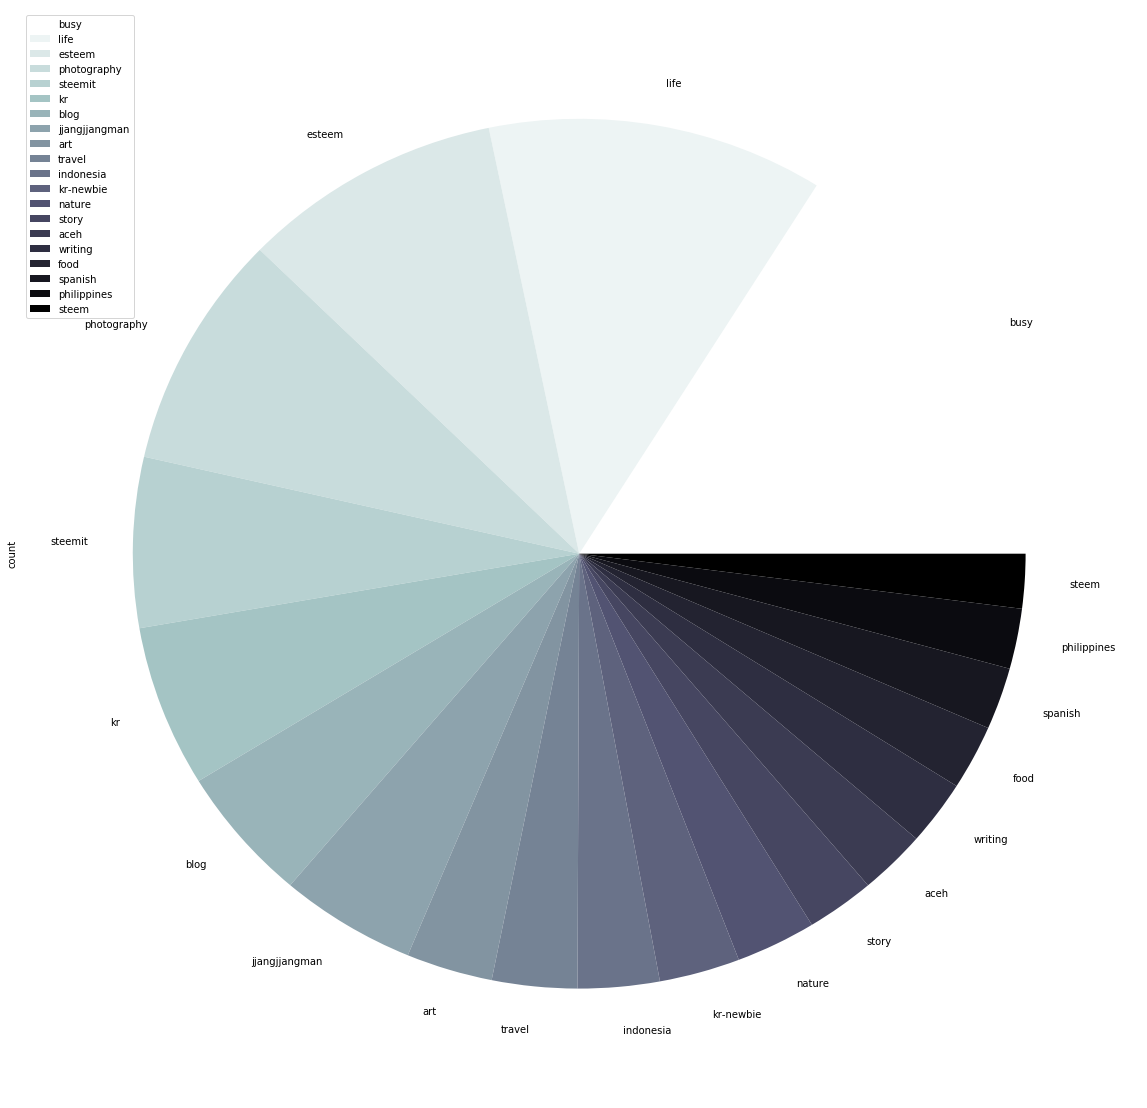

In [316]:
TagST.head(20).plot.pie(y='count',
                        figsize=(20, 20), 
                        colormap='bone_r')                        

I decided to push a little deeper into the tag list for this. Specific numbers are less important once you get down there, so it seemed reasonable.

We see more Korean start showing up, we see the really large Indonesian and Filipino contingent in the tag list, and even "spanish" showing up as another language tag.

I just couldn't live with myself if I didn't put this in a bar or line graph, because we already know what were going to see. Every single thing on Steemit, graphed as a line or bar, has the same shape. We just know.

So let's take a look.

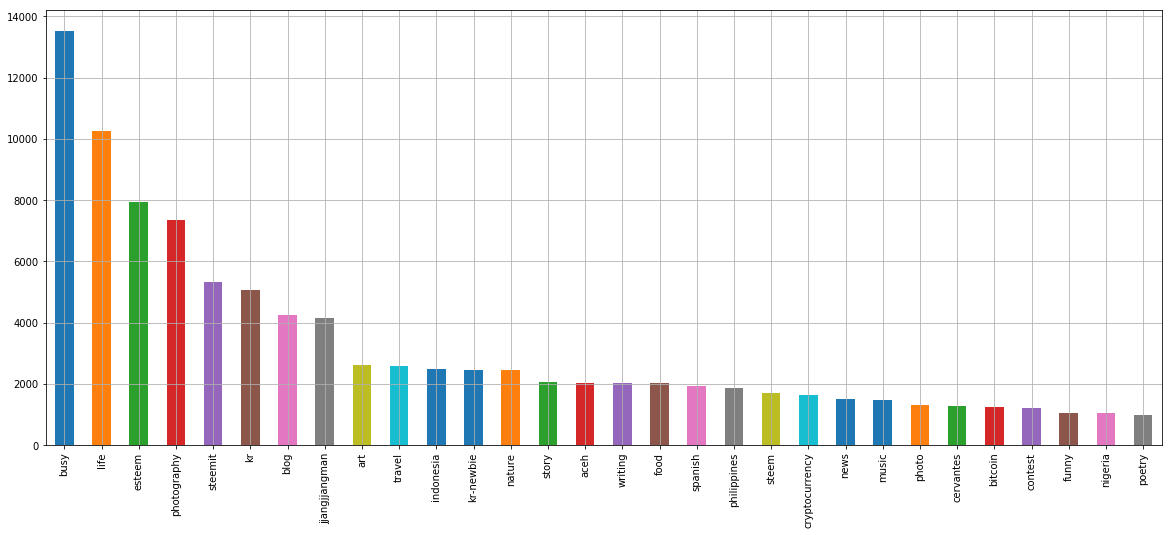

In [318]:
TagST.head(30).plot.bar(y='count',figsize=(20, 8), 
                         grid=True, legend=False)

On the positive side, this is nowhere near as aggressive and exponential decay curve as we've seen elsewhere. In fact, this is positively gentle. It looks more like presentations which talk about content and how the "long tail" is where the bulk of that content resides, being largely undifferentiated by whatever measure is in question.

It's kind of reassuring to see that same thing going on here, in a clear and consistent way.

## *Epilogue*

I'm not going to lie, I am a little bit disappointed. Not just in how hard it was to actually get to this point, but in what I actually turned up.

It turns out that the biggest whales in the platform don't really have any kind of interesting voting pattern when it comes to tags, at least in the last week.

At least not when it comes to topics.

If you have the option, and you want to get in front of them, you might want to start writing in Korean. And posting through [busy.org](http://busy.org). And, for reasons which I cannot determine, writing about "life". Do those three things and you are probably maximizing your ability to get in front of the big whales.

Otherwise? Your best bet is not to chase whales. Outside of the top 10 to 12 tags, you get into the long tail where there is very little differentiation between that content. Write what you want. Look for an audience of people who are interested in it. Post it through [busy.org](http://busy.org) if you're really looking for those up votes from whales.

### Tools

* [Python 3.6](https://www.python.org/)
* [Jupyter Lab](https://github.com/jupyterlab/jupyterlab)
* [SteemData](https://steemdata.com/) created by @furion
* [MongoDB](https://www.mongodb.com/)
* [Pandas](https://pandas.pydata.org/)

**And the number 42.**